In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style("darkgrid")
sns.set_palette("muted")

In [3]:
df = pd.read_csv("insurance_data.csv")

In [4]:
for i in df.columns:
    df[i].replace("?", np.nan, inplace=True)

In [5]:
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,0,NaN,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


<AxesSubplot:xlabel='fraud_reported', ylabel='count'>

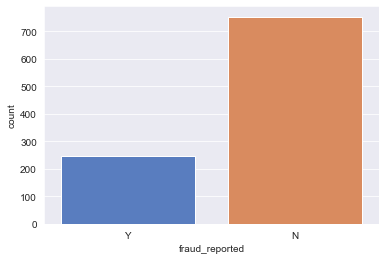

In [6]:
sns.countplot(x="fraud_reported", data=df)

<AxesSubplot:xlabel='police_report_available', ylabel='count'>

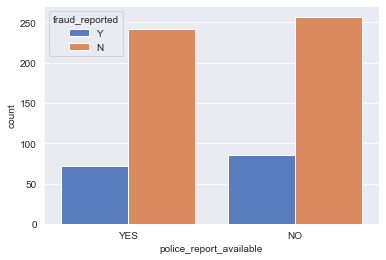

In [7]:
sns.countplot(x="police_report_available", data=df, hue="fraud_reported")

<AxesSubplot:xlabel='auto_make', ylabel='count'>

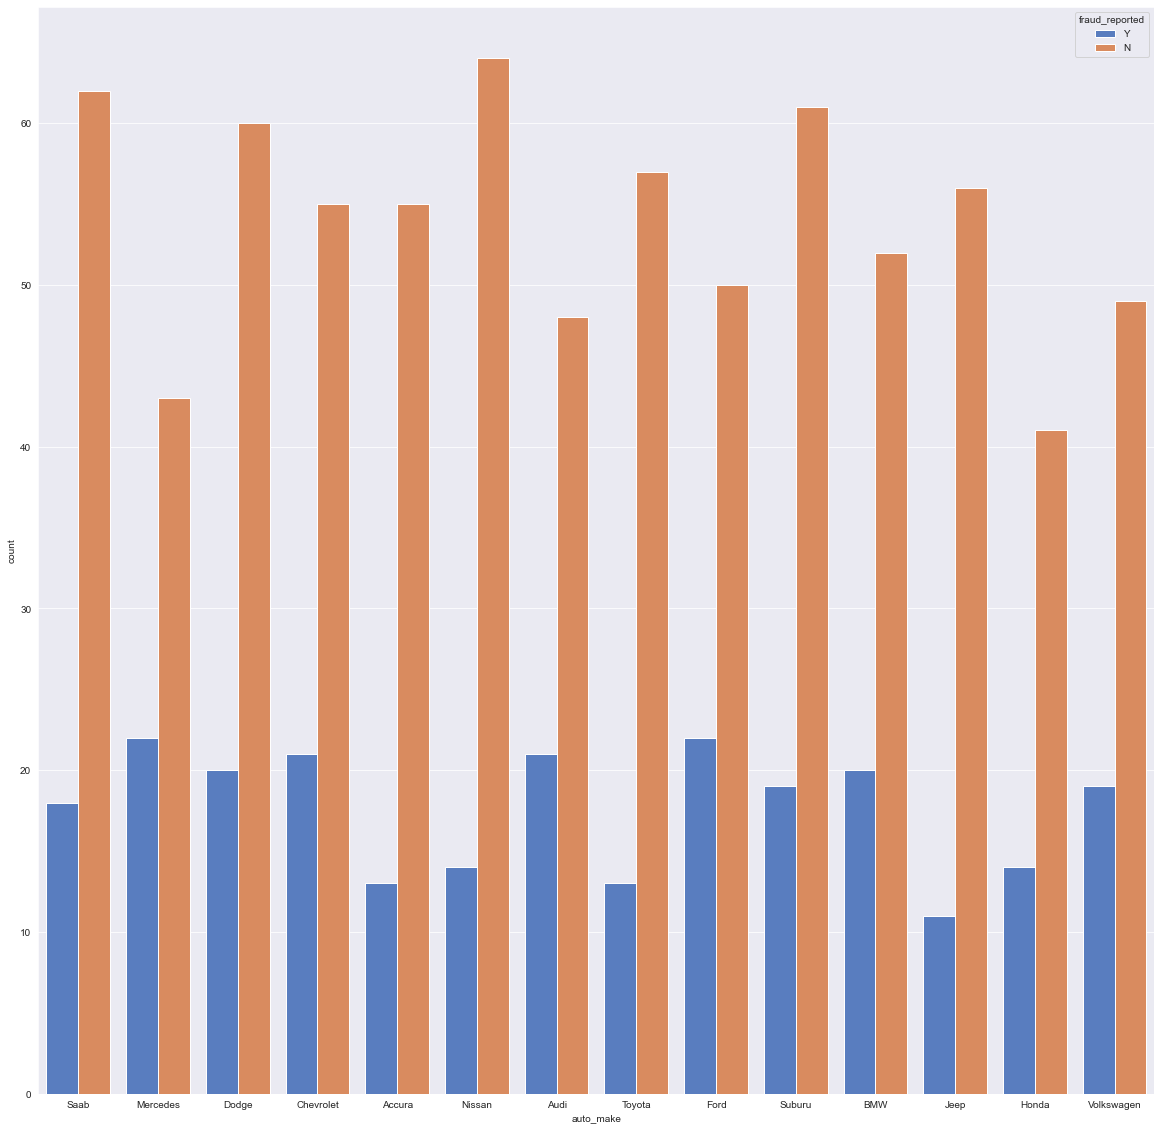

In [8]:
plt.subplots(figsize=(20, 20))
sns.countplot(x="auto_make", data=df, hue="fraud_reported")

### Process Train & Test Data (from KNime)
---
1. Read train & test data.
2. Drop unnecessary columns.
3. Convert categorical to code (label encoding)
4. Use LightGBM to find the importance features.

In [9]:
df_test = pd.read_csv("test_insurance_data.csv")
df_train = pd.read_csv("train_insurance_data.csv")

df_test['fraud_reported'] = pd.Categorical(df_test['fraud_reported'])
df_test['fraud_reported'] = df_test['fraud_reported'].cat.codes

In [10]:
df_train['fraud_reported'] = pd.Categorical(df_train['fraud_reported'])
df_train['fraud_reported'] = df_train['fraud_reported'].cat.codes

In [11]:
y_test = df_test['fraud_reported']
x_test = df_test.drop('fraud_reported', axis=1)

y_train = df_train['fraud_reported']
x_train = df_train.drop('fraud_reported', axis=1)

In [12]:
import lightgbm as lgb
from sklearn.metrics import f1_score

In [13]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

def run_lgb(X_train, X_test, y_train, y_test, test_df):
    params = {
        "objective" : "binary",
       "n_estimators":1000,
       "reg_alpha" : 0.5,
       "reg_lambda":0.5,
       "n_jobs":-1,
       "colsample_bytree":.8,
       "min_child_weight":8,
       "subsample":0.8715623,
       "min_data_in_leaf":30,
       "nthread":4,
       "metric" : "f1",
       "num_leaves" : 10,
       "learning_rate" : 0.01,
       "verbosity" : -1,
       "seed": 60,
       "max_bin":60,
       'max_depth':3,
       'min_gain_to_split':.0222415,
       'scale_pos_weight':1.4,
        'bagging_fraction':0.8
    }
    
    lgtrain = lgb.Dataset(X_train, label=y_train)
    lgval = lgb.Dataset(X_test, label=y_test)
    evals_result = {}
    model = lgb.train(params, lgtrain, 10000, 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=100, 
                      evals_result=evals_result,feval=lgb_f1_score)
    
    pred_test_y = model.predict(test_df, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [14]:
pred_test, model, eval_result = run_lgb(x_train, x_test, y_train, y_test, x_test)
print("Training Completed")

/usr/local/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[100]	training's f1: 0.861868	valid_1's f1: 0.679487
Early stopping, best iteration is:
[61]	training's f1: 0.859649	valid_1's f1: 0.692308
Training Completed


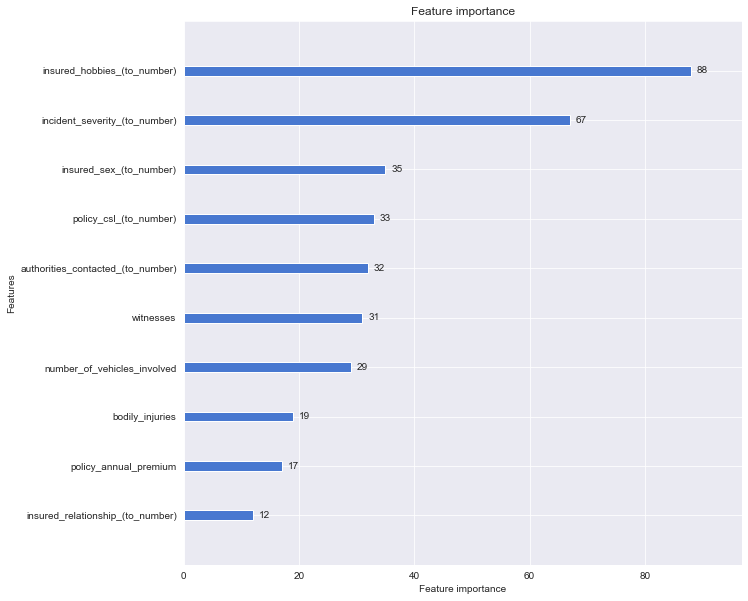

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
lgb.plot_importance(model, max_num_features=10, ax=ax)
plt.show()

<AxesSubplot:>

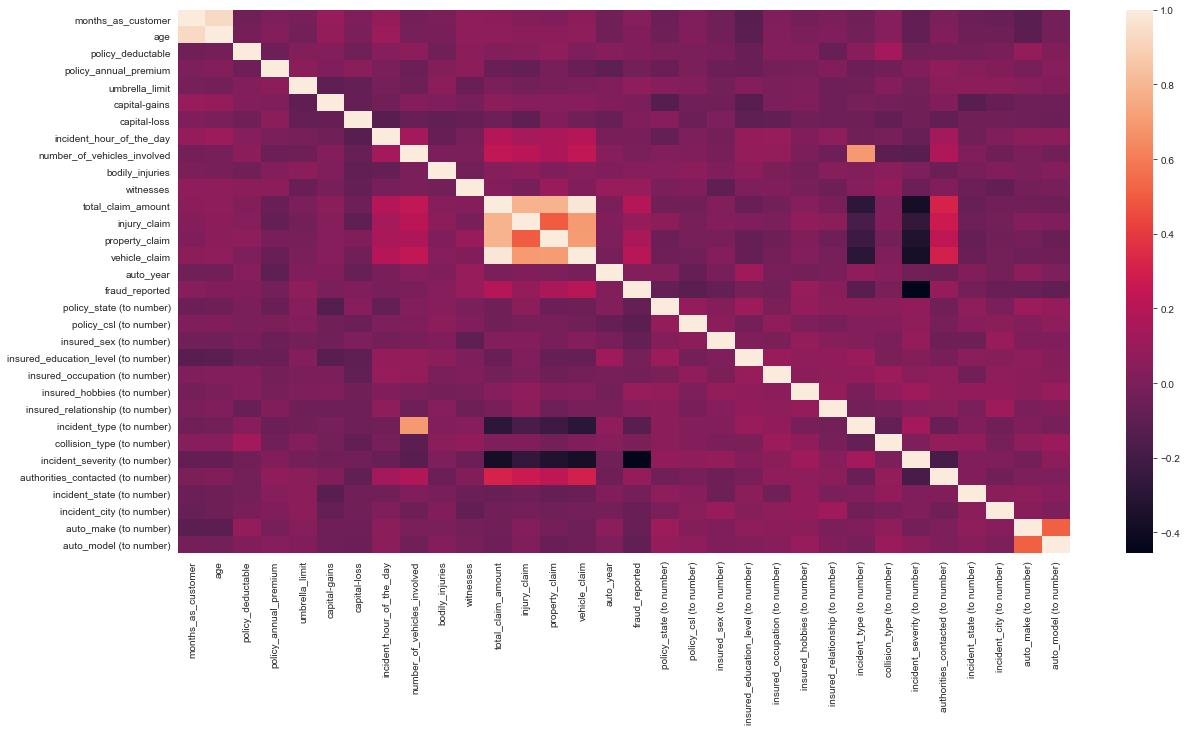

In [18]:
plt.subplots(figsize=(20,10))
sns.heatmap(df_train.corr(),annot=False)